In [28]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split

# Paths
IMAGE_FOLDER = "//kaggle/input/origin-expw/origin"
LABEL_FILE = "/kaggle/input/expression-in-the-wild-expw-dataset/label.lst"

# Step 1: Load label.lst and filter by confidence > 51
columns = ['image_name', 'face_id', 'top', 'left', 'right', 'bottom', 'confidence', 'expression']
data = pd.read_csv(LABEL_FILE, delim_whitespace=True, names=columns)
filtered_data = data[data['confidence'] > 51].reset_index(drop=True)

# Step 2: Split data into train (70%), validation (15%), and test (15%)
train_data, temp_data = train_test_split(filtered_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Step 3: Custom Data Generator Class
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import added

# Step 3: Custom Data Generator Class with Augmentation
class EmotionDataGenerator(Sequence):
    def __init__(self, df, batch_size=32, img_size=(224, 224), shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))

        # Initialize the ImageDataGenerator with augmentation parameters (added)
        self.datagen = ImageDataGenerator(
            rotation_range=10,       # Randomly rotate images by 15 degrees
            width_shift_range=0.05,   # Randomly shift images horizontally (10% of width)
            height_shift_range=0.05,  # Randomly shift images vertically (10% of height)
            shear_range=0.05,         # Randomly apply shear transformation
            zoom_range=0.05,          # Randomly zoom in/out
            horizontal_flip=True,     # Randomly flip images horizontally
            fill_mode='nearest'      # Fill in newly created pixels
        )

        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Generate indices for the current batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.df.iloc[batch_indices]
        
        X, y = self.__data_generation(batch_data)
        return X, y

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch if needed
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        X = np.empty((self.batch_size, *self.img_size, 3))  # RGB images
        y = np.empty((self.batch_size), dtype=int)

        for i, row in enumerate(batch_data.itertuples()):
            img_path = os.path.join(IMAGE_FOLDER, row.image_name)

            try:
                # Load and crop the image
                img = Image.open(img_path)
                cropped_img = img.crop((row.left, row.top, row.right, row.bottom))
                resized_img = cropped_img.resize(self.img_size)  # Resize to target size
                X[i] = np.array(resized_img) / 255.0  # Normalize pixel values
                y[i] = row.expression  # Get the expression label

            except Exception as e:
                print(f"Error loading image {row.image_name}: {e}")

        # One-hot encode the labels
        y = to_categorical(y, num_classes=7)

        # Apply data augmentation
        X_augmented = next(self.datagen.flow(X, batch_size=self.batch_size, shuffle=False))

        return X_augmented, y



# Step 4: Initialize Generators for Training, Validation, and Testing
batch_size = 32
img_size = (224, 224)

train_gen = EmotionDataGenerator(train_data, batch_size=batch_size, img_size=img_size)
val_gen = EmotionDataGenerator(val_data, batch_size=batch_size, img_size=img_size)
test_gen = EmotionDataGenerator(test_data, batch_size=batch_size, img_size=img_size)


/tmp/ipykernel_30/91691861.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(LABEL_FILE, delim_whitespace=True, names=columns)


In [29]:
import tensorflow as tf

# Define the CNN Model (Deep ConvNet)
def build_cnn(input_shape=(224, 224, 3), num_classes=7):
    model = tf.keras.models.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        # Flatten and Fully Connected Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(490, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(196, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(49, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer for 7 classes
    ])
    return model

# Instantiate the model
model = build_cnn()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 490)            │    42,399,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 490)            │         1,960 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 490)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 196)            │        96,236 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 196)            │           784 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 49)             │         9,653 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 49)             │           196 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 49)             │             

 Total params: 42,602,533 (162.52 MB)

 Trainable params: 42,600,615 (162.51 MB)

 Non-trainable params: 1,918 (7.49 KB)

In [30]:
epochs = 15  # You can adjust the number of epochs

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    verbose=1
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


972/972 ━━━━━━━━━━━━━━━━━━━━ 722s 720ms/step - accuracy: 0.3207 - loss: 1.8848 - val_accuracy: 0.4555 - val_loss: 1.4375
Epoch 2/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 703s 719ms/step - accuracy: 0.4661 - loss: 1.4412 - val_accuracy: 0.4722 - val_loss: 1.4535
Epoch 3/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 700s 716ms/step - accuracy: 0.5132 - loss: 1.3346 - val_accuracy: 0.4896 - val_loss: 1.3635
Epoch 4/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 716s 733ms/step - accuracy: 0.5553 - loss: 1.2483 - val_accuracy: 0.5503 - val_loss: 1.2442
Epoch 5/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 733s 724ms/step - accuracy: 0.5716 - loss: 1.2020 - val_accuracy: 0.4793 - val_loss: 1.3933
Epoch 6/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 699s 715ms/step - accuracy: 0.5988 - loss: 1.1438 - val_accuracy: 0.6052 - val_loss: 1.1373
Epoch 7/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 705s 721ms/step - accuracy: 0.5932 - loss: 1.1592 - val_accuracy: 0.5757 - val_loss: 1.2124
Epoch 8/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 712s 728ms/step - accuracy: 0.6156 - loss: 1.10

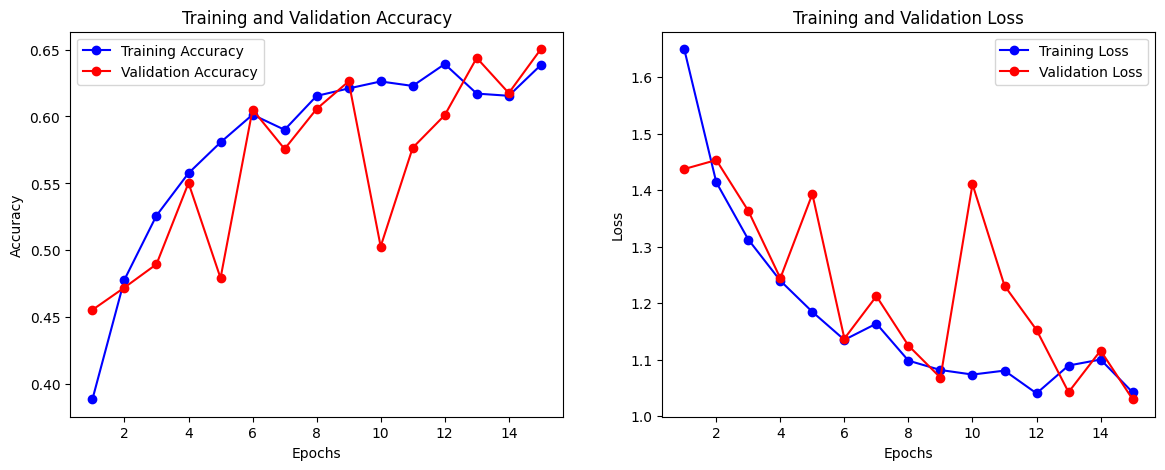

In [31]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy/loss
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot
plot_training_history(history)


In [32]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


208/208 ━━━━━━━━━━━━━━━━━━━━ 125s 603ms/step - accuracy: 0.6405 - loss: 1.0485
Test Loss: 1.0318
Test Accuracy: 64.39%


In [45]:
# Collect all true labels from the test generator
y_true = np.concatenate([y for _, y in test_gen], axis=0)  # Collect true labels
y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class labels

# Get predictions on the test data
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels




208/208 ━━━━━━━━━━━━━━━━━━━━ 118s 569ms/step


In [46]:
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")


Length of y_true: 6656
Length of y_pred: 6656


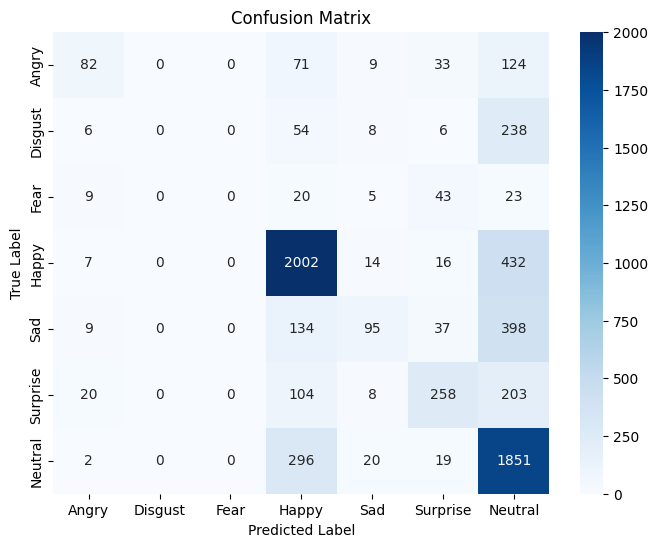

              precision    recall  f1-score   support

           0       0.61      0.26      0.36       319
           1       0.00      0.00      0.00       312
           2       0.00      0.00      0.00       100
           3       0.75      0.81      0.78      2471
           4       0.60      0.14      0.23       673
           5       0.63      0.44      0.51       593
           6       0.57      0.85      0.68      2188

    accuracy                           0.64      6656
   macro avg       0.45      0.36      0.37      6656
weighted avg       0.61      0.64      0.60      6656



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))